In [3]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
#source: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html

In [5]:
imagePath = "Images/Blurry/"

img = cv2.imread(imagePath+"MFGTMP_191024160002_A02f304d2.tif",0)

# create histogram and check

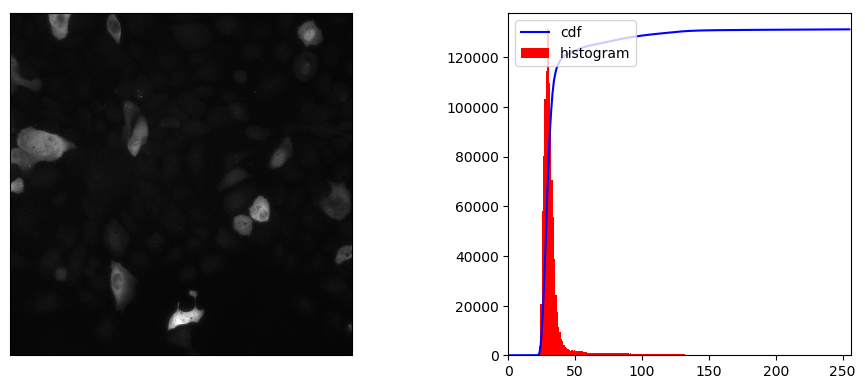

In [44]:
hist, bins = np.histogram(img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), dpi=100)

ax1.imshow(img, 'gray')
ax1.get_xaxis().set_visible(False) # hide x-axis
ax1.get_yaxis().set_visible(False) # hide y-axis

ax2.plot(cdf_normalized, color = 'b')
ax2.hist(img.flatten(),256,[0,256], color = 'r')
ax2.set_xlim([0,256])
ax2.legend(('cdf','histogram'), loc = 'upper left')
# now set the histogram aspect ratio
asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
ax2.set_aspect(asp)

plt.tight_layout(1.10)
plt.show()

In [39]:
print(len(bins[50:]))

207


In [29]:
np.mean(hist)

4096.0

In [45]:
sum(np.diff(bins[50:])*hist[50:])

69860.0

# find min histo val (excluding 0), apply  histo equalization 

In [21]:
# Using masked array concept array from Numpy.
# For masked array, all operations are performed on non-masked elements.
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

In [22]:
img2 = cdf[img]

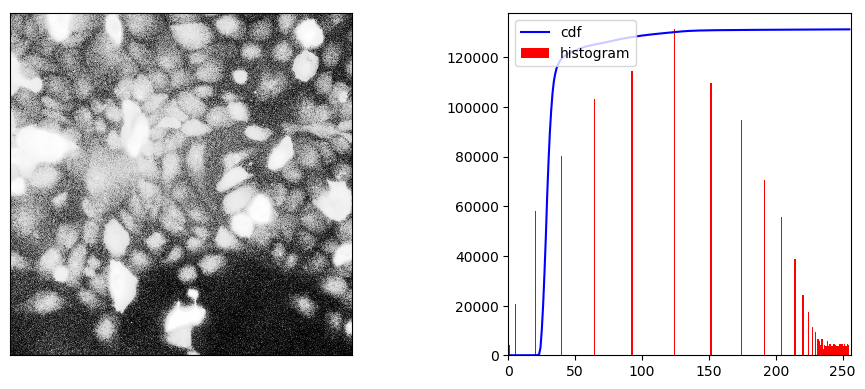

In [23]:
hist, bins = np.histogram(img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), dpi=100)

ax1.imshow(img2, 'gray')
ax1.get_xaxis().set_visible(False) # hide x-axis
ax1.get_yaxis().set_visible(False) # hide y-axis

ax2.plot(cdf_normalized, color = 'b')
ax2.hist(img2.flatten(),256,[0,256], color = 'r')
ax2.set_xlim([0,256])
ax2.legend(('cdf','histogram'), loc = 'upper left')
# now set the histogram aspect ratio
asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
ax2.set_aspect(asp)

plt.tight_layout(1.10)
plt.show()

# Using openCV's CLAHE (Contrast Limited Adaptive Histogram Equalization)

In [32]:
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8)) # set clipLimit to adj how much detail to bring up
cl1 = clahe.apply(img)

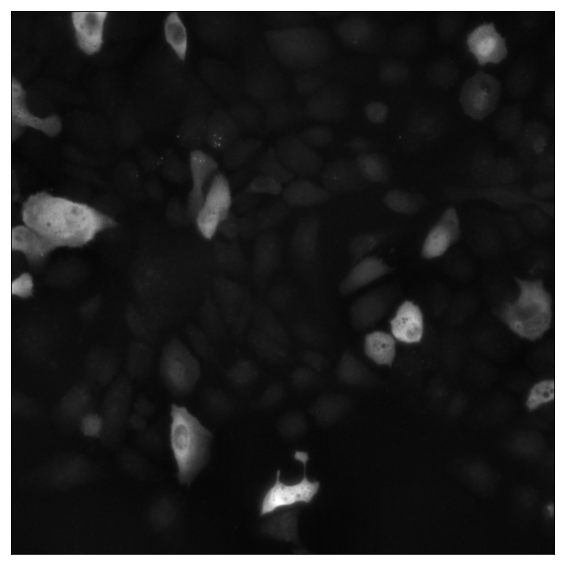

In [33]:
plt.figure(figsize = (10,10))
plt.imshow(cl1, cmap='gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [26]:
def variance_of_laplacian(image):
# compute the Laplacian of the image and then return the focus
# measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [29]:
fm = variance_of_laplacian(img)
fm2 = variance_of_laplacian(cl1)

print('variance before = {0:.2f}'.format(fm))
print('variance after = {0:.2f}'.format(fm2))

variance before = 25.48
variance after = 163.85


# Canny Edge Detection

In [ ]:
#1st try it with a sharp picture

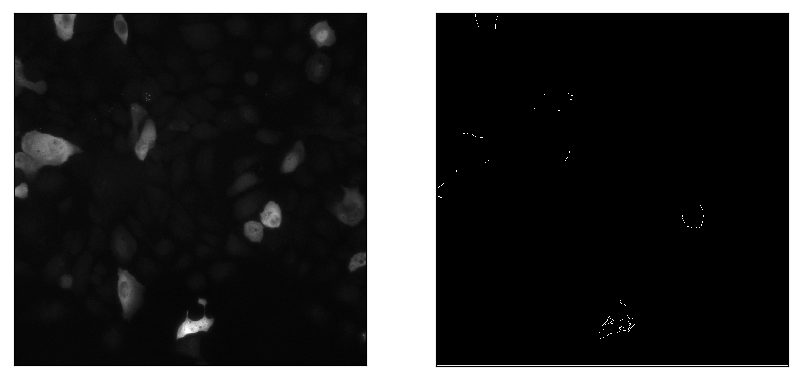

In [63]:
edges = cv2.Canny(img,100,200) # source, minVal, maxVal, aperture_size for Sobel Kernel (def=3), L2gradient (def=False) 

plt.figure(figsize = (10,10), dpi=100)
plt.subplot(1,2,1)
plt.imshow(img, 'gray')
plt.xticks([]),plt.yticks([]) #hide ticks

plt.subplot(1,2,2)
plt.imshow(edges, 'gray')
plt.xticks([]),plt.yticks([]) #hide ticks

plt.show()

In [64]:
fmCny = variance_of_laplacian(edges)
print('variance before = {0:.2f}'.format(fm))
print('variance after = {0:.2f}'.format(fmCny))

variance before = 25.48
variance after = 633.40


In [152]:
# second try it with a blurry picture
blurryImage = cv2.imread("Images/Blurry/MFGTMP_191024160001_A02f50d2.tif",0)

In [103]:
edgesBlur = cv2.Canny(blurryImage,100,200)

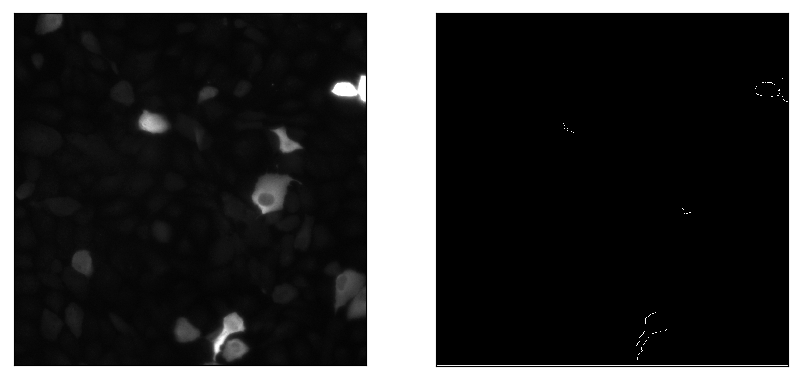

In [104]:
plt.figure(figsize = (10,10), dpi=100)
plt.subplot(1,2,1)
plt.imshow(blurryImage, 'gray')
plt.xticks([]),plt.yticks([]) #hide ticks

plt.subplot(1,2,2)
plt.imshow(edgesBlur, 'gray')
plt.xticks([]),plt.yticks([]) #hide ticks

plt.show()

In [65]:
fmBlur = variance_of_laplacian(blurryImage)
fmBlurCny = variance_of_laplacian(edgesBlur)
print('variance before = {0:.2f}'.format(fmBlur))
print('variance after = {0:.2f}'.format(fmBlurCny))

variance before = 20.81
variance after = 448.85


# check for overexposed regions

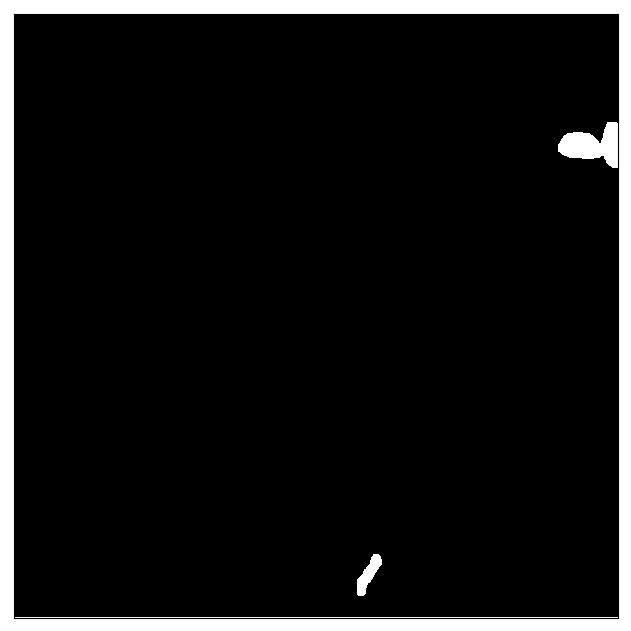

In [105]:
# Gaussian blur
blurred = cv2.GaussianBlur(blurryImage,(5,5),cv2.BORDER_DEFAULT)

# threshold
th = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1] # cv2.threshold gives 2 outputs, ret & th
                                                            # select the 2nd one

# perform erosions and dilations to remove blobs of noise from image
th = cv2.erode(th, None, iterations=2)
th = cv2.dilate(th, None, iterations=4)

plt.figure(figsize = (8,8))
plt.subplot(1,1,1)
plt.imshow(th, 'gray')
plt.xticks([]),plt.yticks([]) #hide ticks

plt.show()

In [ ]:
# perform connected component analysis on thresholded image
from skimage import measure

labels = measure.label(th, neighbors=8, background=0)

In [186]:
# initialize a mask to store only the large components
mask = np.zeros(th.shape, dtype='uint8')

In [187]:
# loop over unique components
for label in np.unique(labels):
    if label ==0: #ignore background label
        continue
    
    # otherwise, construct the label mask 
    # thiis mask is just for the current label
    labelMask = np.zeros(th.shape, dtype='uint8')
    labelMask[labels == label] = 255
    
    # count the # of non-zero pixels 
    numPixels = cv2.countNonZero(labelMask)
    
    # if # of pixels in the component is greater than a threshold (300),
    # then add it to mask of large blobs
    if numPixels > 300:
        mask = cv2.add(mask, labelMask)

In [244]:
print(np.unique(labels)[-1])

2


In [168]:
# did we find any overexposed blobs?
print(np.count_nonzero(mask))

5964


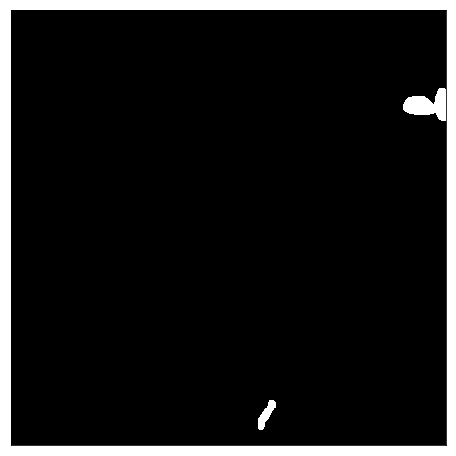

In [169]:
# visualizing the resulting mask
plt.figure(figsize = (8,8))
plt.subplot(1,1,1)
plt.imshow(mask, 'gray')
plt.xticks([]),plt.yticks([]) #hide ticks

plt.show()

In [101]:
# from imutils
# https://github.com/jrosebr1/imutils/blob/master/imutils/convenience.py
def grab_contours(cnts):
    # if the length the contours tuple returned by cv2.findContours
    # is '2' then we are using either OpenCV v2.4, v4-beta, or
    # v4-official
    if len(cnts) == 2:
        cnts = cnts[0]

    # if the length of the contours tuple is '3' then we are using
    # either OpenCV v3, v4-pre, or v4-alpha
    elif len(cnts) == 3:
        cnts = cnts[1]

    # otherwise OpenCV has changed their cv2.findContours return
    # signature yet again and I have no idea WTH is going on
    else:
        raise Exception(("Contours tuple must have length 2 or 3, "
            "otherwise OpenCV changed their cv2.findContours return "
            "signature yet again. Refer to OpenCV's documentation "
            "in that case"))

    # return the actual contours array
    return cnts

In [114]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return cnts, boundingBoxes

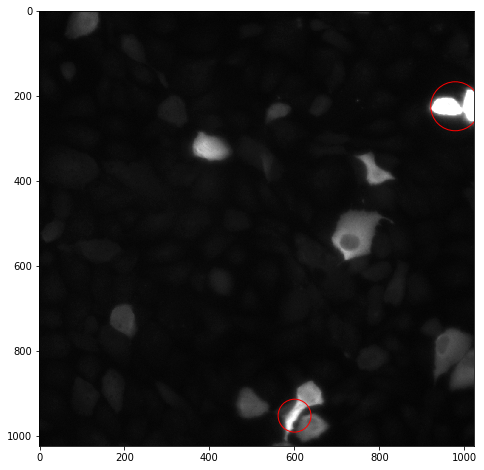

In [139]:
# find the contours in the mask
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = grab_contours(cnts)
# sort from left to right
cnts = sort_contours(cnts)[0]

# now draw circles on the image
from matplotlib.patches import Circle
fig,ax = plt.subplots(1, figsize=(8,8))
ax.set_aspect('equal')
ax.imshow(blurryImage, 'gray')

# now loop over the contours
for (i, c) in enumerate(cnts):
    (x, y, w, h) = cv2.boundingRect(c)
    # compute the min enclosing circle
    ((cX, cY), radius) = cv2.minEnclosingCircle(c)

    circ = Circle((cX,cY), radius, color='r', linewidth=1, fill=False)
    ax.add_patch(circ)

plt.show()

In [209]:
# dilate the mask
dilatedMask = cv2.dilate(mask, None, iterations=30)

In [210]:
# masking out the original image
#masked_blurryImage = cv2.subtract(blurryImage, dilatedMask)

In [236]:
# different approach
# blur out masked regions
blurredBlurryImage = cv2.GaussianBlur(blurryImage, (101, 101), 0)
out = np.where(dilatedMask, blurredBlurryImage, blurryImage)

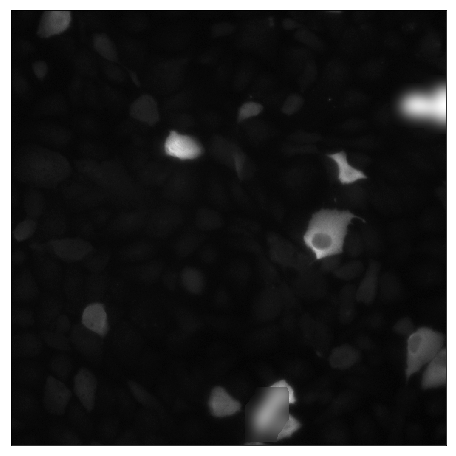

In [237]:
# showing results
# blurring out masked regions of the original image
plt.figure(figsize = (8,8))
plt.subplot(1,1,1)
plt.imshow(out, 'gray')
plt.xticks([]),plt.yticks([]) #hide ticks

plt.show()

In [238]:
# variance after blur masking
fmBlur = variance_of_laplacian(blurryImage)
fmBlurMasked = variance_of_laplacian(out)
print('variance before = {0:.2f}'.format(fmBlur))
print('variance after = {0:.2f}'.format(fmBlurMasked))

variance before = 20.81
variance after = 19.82


In [239]:
# edge detection after blur masking
masked_edgesBlur = cv2.Canny(out,100,200)

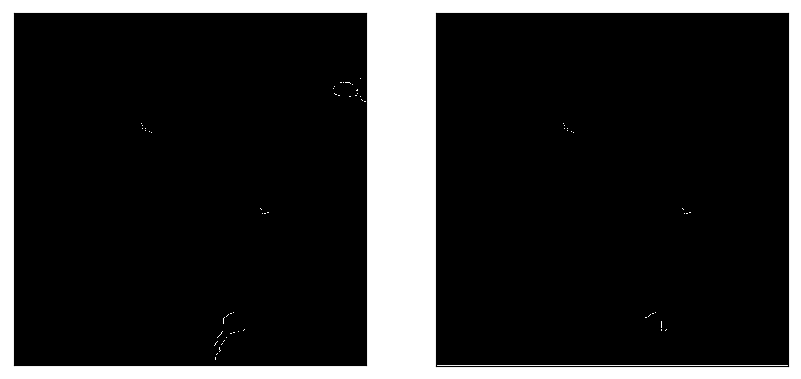

In [240]:
plt.figure(figsize = (10,10), dpi=100)
plt.subplot(1,2,1)
plt.imshow(edgesBlur, 'gray')
plt.xticks([]),plt.yticks([]) #hide ticks

plt.subplot(1,2,2)
plt.imshow(masked_edgesBlur, 'gray')
plt.xticks([]),plt.yticks([]) #hide ticks

plt.show()

In [241]:
# variance after blur masking and edge detection
fmBlur = variance_of_laplacian(edgesBlur)
fmBlurMasked = variance_of_laplacian(masked_edgesBlur)
print('variance before = {0:.2f}'.format(fmBlur))
print('variance after = {0:.2f}'.format(fmBlurMasked))

variance before = 448.85
variance after = 171.28


In [ ]:
# check an image with low overall signals

In [3]:
img2 = cv2.imread("Images/K342N/MFGTMP_191023110002_C01f61d2.TIF",0)

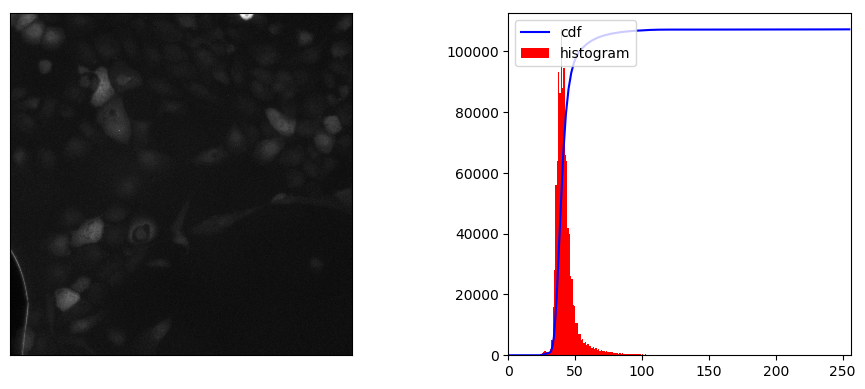

In [40]:
hist, bins = np.histogram(img2.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), dpi=100)

ax1.imshow(img2, 'gray')
ax1.get_xaxis().set_visible(False) # hide x-axis
ax1.get_yaxis().set_visible(False) # hide y-axis

ax2.plot(cdf_normalized, color = 'b')
ax2.hist(img2.flatten(),256,[0,256], color = 'r')
ax2.set_xlim([0,256])
ax2.legend(('cdf','histogram'), loc = 'upper left')
# now set the histogram aspect ratio
asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
ax2.set_aspect(asp)

plt.tight_layout(1.10)
plt.show()

In [41]:
print(len(bins[50:]))

207


In [43]:
sum(np.diff(bins[50:])*hist[50:])

107250.0